# Etude de cas : analyse des fichiers de logs des cyclistes

Objectif: A partir des fichiers contenu dans le dossier ./data/Cyclistes, calculer la durée de chacun des trajets effectués par chaque cycliste.

In [123]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, when, sum as Fsum, row_number
from pyspark.sql.window import Window
from datetime import datetime

## 1)  Charger la donnée
Créez une seesion Spark et chargez les données Cyclistes.

In [91]:
spark = SparkSession.builder.getOrCreate()

In [92]:
df = spark.read.option("header","true").csv("data/Cyclistes/*.csv")
df.show(5)

+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| id|          timestamp|sur_velo| velo|             vitesse|           position|destination_finale|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| 12|2018-01-01 00:01:00|   False|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:02:00|   False|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:03:00|   False|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:04:00|   False|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:05:00|   False|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
only showing top 5 rows



## 2) Vérifier le nombre de cyclistes

Comptez le nombre d'id uniques.

In [93]:
df.select("id").distinct().count()

50

## 3) Transformer la colonne timestamp

Lorsqu'on vérifie le type de donnée de la colonne timestamp, on voit qu'on a une chaîne de caractères. Pour calculer une durée on voudrait transformer en date exploitable en tant que telle.
A l'aide d'une fonction udf, créez une nouvelle colonne date qui contiendra le résultat de la transformation des chaînes de caractères de la colonne timestamp en véritables timestamps.

In [95]:
def parse_timestamp(ts_str):
    if ts_str is None:
        return None
    return datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S")  

parse_timestamp_udf = udf(parse_timestamp, TimestampType())

df = df.withColumn("date", parse_timestamp_udf(col("timestamp")))

## 4) Durée des trajets par id.

1) Trouvez les dates min/max par état de sur_velo, puis par id ET par état de sur_velo.

In [96]:
df_etat = (
    df.groupBy("sur_velo")
      .agg(
          F.min("date").alias("date_min"),
          F.max("date").alias("date_max")
      )
)

df_etat.show()

+--------+-------------------+-------------------+
|sur_velo|           date_min|           date_max|
+--------+-------------------+-------------------+
|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
|    True|2018-01-01 01:47:00|2018-01-31 21:32:00|
+--------+-------------------+-------------------+



In [74]:
df_id_etat = (
    df.groupBy("id", "sur_velo")
      .agg(
          F.min("date").alias("date_min"),
          F.max("date").alias("date_max")
      )
)

df_id_etat.show()

+---+--------+-------------------+-------------------+
| id|sur_velo|           date_min|           date_max|
+---+--------+-------------------+-------------------+
| 12|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 43|    True|2018-01-01 07:44:00|2018-01-30 18:53:00|
| 43|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 15|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 12|    True|2018-01-01 08:57:00|2018-01-31 16:49:00|
| 15|    True|2018-01-01 10:19:00|2018-01-31 20:31:00|
| 29|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 36|    True|2018-01-01 08:47:00|2018-01-31 21:32:00|
| 41|    True|2018-01-01 08:38:00|2018-01-31 20:35:00|
| 36|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 41|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 29|    True|2018-01-01 05:24:00|2018-01-30 22:29:00|
| 42|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 47|    True|2018-01-01 04:09:00|2018-01-30 16:14:00|
| 47|   False|2018-01-01 00:01:00|2018-02-01 00:00:00|
| 10|    T

2) Le résultat n'est pas trés pertinent, il faudrait plutôt le début et la fin de chaque trajet par id. Pour cela, il faudrait détecter les changements d'état "sur_vélo".

Créez une fonction python (voir fonction udf) qui permet de detecter ces changements d'état.
Utilisez la classe Window() et la fonction F.lag() avec votre fonction udf pour créer une nouvelle colonne que vous appellerez changement, contenant un 0 si l'état précedent de sur_velo est le même et un 1 si l'état vient de changer pour chaque id.

In [97]:
w = Window.partitionBy("id").orderBy("date")

df = df.withColumn("prev_sur_velo", F.lag("sur_velo").over(w))

def detect_change(current, previous):
    if previous is None:   # début du trajet
        return 0
    return 1 if current != previous else 0

change_udf = udf(detect_change, IntegerType())

df = df.withColumn(
    "changement",
    change_udf(F.col("sur_velo"), F.col("prev_sur_velo"))
)


In [104]:
df_changes = df.filter(F.col("changement") == 1)

# fenêtre : 2 lignes avant jusqu'à la ligne actuelle
w_before = Window.partitionBy("id").orderBy("date").rowsBetween(-2, 0)

df_preview = (
    df.withColumn("is_change_window", F.max("changement").over(w_before))
      .filter(F.col("is_change_window") == 1)
)
df_preview = df_preview.select(
    "id",
    "date",
    "sur_velo",
    "prev_sur_velo",
    "changement",
    "vitesse"
).orderBy("id", "date")
df_preview.show(10, truncate=False)

+---+-------------------+--------+-------------+----------+-------------------+
|id |date               |sur_velo|prev_sur_velo|changement|vitesse            |
+---+-------------------+--------+-------------+----------+-------------------+
|10 |2018-01-01 08:35:00|True    |False        |1         |0.7674066326248462 |
|10 |2018-01-01 08:36:00|False   |True         |1         |0.33856174968743213|
|10 |2018-01-01 08:37:00|False   |False        |0         |0.33856174968743213|
|10 |2018-01-01 08:38:00|False   |False        |0         |0.33856174968743213|
|10 |2018-01-01 17:32:00|True    |False        |1         |0.7674066326248462 |
|10 |2018-01-01 17:33:00|False   |True         |1         |0.33856174968743213|
|10 |2018-01-01 17:34:00|False   |False        |0         |0.33856174968743213|
|10 |2018-01-01 17:35:00|False   |False        |0         |0.33856174968743213|
|10 |2018-01-02 08:35:00|True    |False        |1         |0.7674066326248462 |
|10 |2018-01-02 08:36:00|False   |True  

3) Grâce à cette nouvelle colonne changement, trouvez un moyen qui permettra de numeroter les trajets pour chaque id et stockez les résulats dans une nouvelle colonne appelée numero_de_trajet.

In [118]:
# Colonne trajet_actif : 1 uniquement si le changement correspond à montée sur le vélo
df = df.withColumn(
    "trajet_actif",
    when((col("prev_sur_velo") == False) & (col("sur_velo") == True), 1).otherwise(0)
)

w = Window.partitionBy("id").orderBy("date")

df = df.withColumn(
    "numero_de_trajet",
    Fsum("trajet_actif").over(w)
)

In [125]:
# Fenêtre par id et numéro de trajet, ordonnée par date
w = Window.partitionBy("id", "numero_de_trajet").orderBy("date")

# Numéroter les lignes dans chaque trajet
df_first_line = df.withColumn("rn", row_number().over(w)) \
                  .filter((col("rn") == 1) & (col("id") == 48)) \
                  .select("id", "numero_de_trajet", "date", "sur_velo", "prev_sur_velo", "changement") \
                  .orderBy("id", "numero_de_trajet")

df_first_line.show(10, truncate=False)

+---+----------------+-------------------+--------+-------------+----------+
|id |numero_de_trajet|date               |sur_velo|prev_sur_velo|changement|
+---+----------------+-------------------+--------+-------------+----------+
|48 |0               |2018-01-01 00:01:00|False   |NULL         |0         |
|48 |1               |2018-01-01 02:15:00|True    |False        |1         |
|48 |2               |2018-01-01 17:53:00|True    |False        |1         |
|48 |3               |2018-01-03 02:15:00|True    |False        |1         |
|48 |4               |2018-01-03 17:53:00|True    |False        |1         |
|48 |5               |2018-01-05 02:15:00|True    |False        |1         |
|48 |6               |2018-01-05 17:53:00|True    |False        |1         |
|48 |7               |2018-01-07 02:15:00|True    |False        |1         |
|48 |8               |2018-01-07 17:53:00|True    |False        |1         |
|48 |9               |2018-01-08 02:15:00|True    |False        |1         |

4) Il suffit maintenant de repêter la première étape, c'est a dire récupérer le début et le fin de chaque trajet pour chaque id, puis calculer la durée des trajets. 

(Pensez à récuperer les "vrai trajet au préalable (avec un état sur_vélo = 1).

In [126]:
df_trajets = df.filter(col("sur_velo") == True)

In [132]:
trajets_summary = (
    df.filter(col("sur_velo") == True)
      .groupBy("id", "numero_de_trajet")
      .agg(
          F.min("date").alias("debut_trajet"),
          F.max("date").alias("fin_trajet"),
          F.avg("vitesse").alias("vitesse_moyenne")
      )
      .withColumn(
          "duree_trajet_min",
          F.col("fin_trajet").cast("long") - F.col("debut_trajet").cast("long")  # durée en secondes
      )
      .withColumn(
          "duree_trajet_min",
          ((F.col("duree_trajet_min") / 60) + 1).cast("double")  # ajout d'une minute => postulat : minute débuté, minute terminé
      )
      .orderBy("id", "numero_de_trajet")
)

In [146]:
trajets_summary.filter(col("id") == 51) \
               .select("id", "numero_de_trajet", "debut_trajet", "fin_trajet", "duree_trajet_min", "vitesse_moyenne") \
               .orderBy("numero_de_trajet") \
               .show(50, truncate=False)

+---+----------------+-------------------+-------------------+----------------+--------------------+
|id |numero_de_trajet|debut_trajet       |fin_trajet         |duree_trajet_min|vitesse_moyenne     |
+---+----------------+-------------------+-------------------+----------------+--------------------+
|51 |1               |2018-01-01 06:29:00|2018-01-01 07:15:00|47.0            |0.04249999999999999 |
|51 |2               |2018-01-01 12:18:00|2018-01-01 13:00:00|43.0            |0.046411793182026324|
|51 |3               |2018-01-02 06:29:00|2018-01-02 07:15:00|47.0            |0.04249999999999999 |
|51 |4               |2018-01-02 13:16:00|2018-01-02 14:01:00|46.0            |0.04917701302284286 |
|51 |5               |2018-01-04 06:29:00|2018-01-04 07:15:00|47.0            |0.04249999999999999 |
|51 |6               |2018-01-04 12:18:00|2018-01-04 13:04:00|47.0            |0.04249999999999999 |
|51 |7               |2018-01-05 06:29:00|2018-01-05 07:15:00|47.0            |0.0424999999

## 5) Data visualisation

Convertissez votre dataframe pyspark en dataframe pandas.

In [134]:
df_pandas = trajets_summary.toPandas()

1) A l'aide des librairies matplotlib et/ou seaborn, réalisez un graphique en barre montrant le temps total passé à vélo par chaque cycliste.

In [ ]:
import seaborn as sns
%matplotlib inline

In [147]:
# Conversion de l'échelle
def convertir_duree(minutes):
    if minutes < 60:
        return minutes, "minutes"
    elif minutes < 1440:  # moins de 24h
        return minutes / 60, "heures"
    else:
        return minutes / 1440, "jours"

# Appliquer la conversion
temps_total["duree"], temps_total["unite"] = zip(*temps_total["duree_trajet_min"].apply(convertir_duree))

# On prend l'unité majoritaire pour le graphique
unite_graph = temps_total["unite"].mode()[0]

# Filtrer pour l'unité du graphe
temps_total_graph = temps_total[temps_total["unite"] == unite_graph]

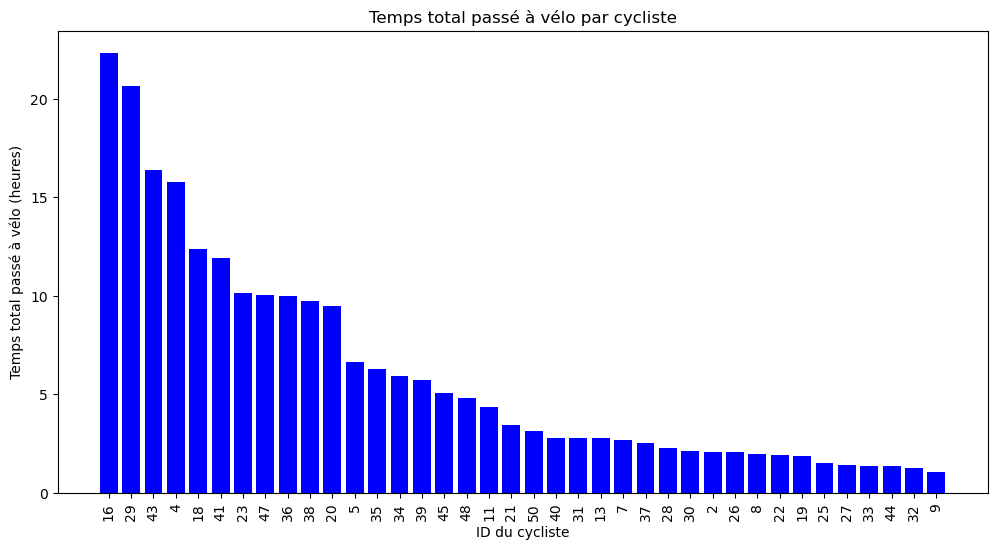

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(temps_total_graph["id"].astype(str), temps_total_graph["duree"], color="blue")
plt.xlabel("ID du cycliste")
plt.ylabel(f"Temps total passé à vélo ({unite_graph})")
plt.title("Temps total passé à vélo par cycliste")
plt.xticks(rotation=90)
plt.show()

2) Réalisez un graphique en barre qui affiche le temps de chaque trajet d'un cycliste. Faites en sorte qu'on puisse choisir un id et afficher les trajets de cet id.

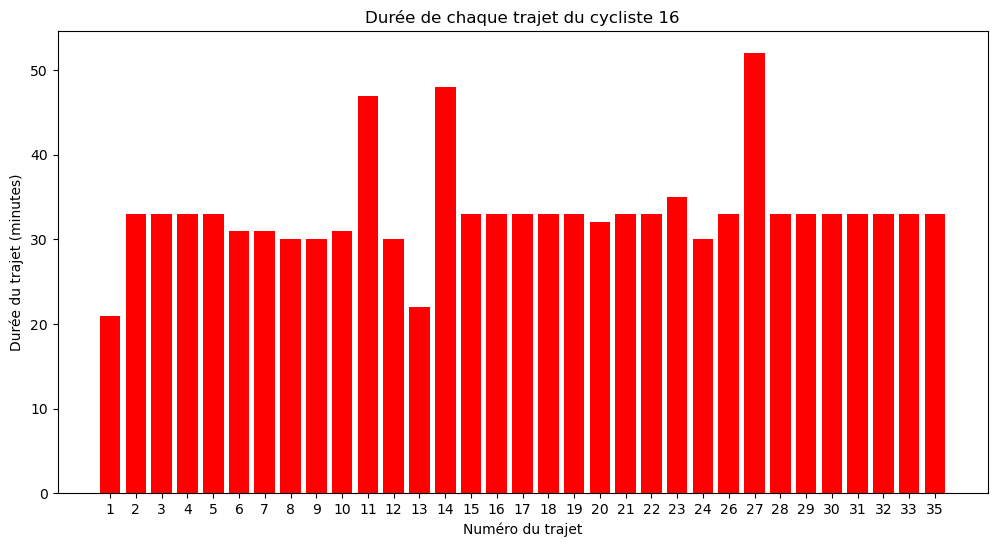

In [150]:
import matplotlib.pyplot as plt

# Choisir l'id du cycliste
id_cycliste = "16"

# Filtrer les trajets pour cet id
trajets_cycliste = df_pandas[df_pandas["id"] == id_cycliste].sort_values("numero_de_trajet")

# Fonction de conversion automatique
def convertir_duree(minutes):
    if minutes < 60:
        return minutes, "minutes"
    elif minutes < 1440:  # moins de 24h
        return minutes / 60, "heures"
    else:
        return minutes / 1440, "jours"

# Appliquer la conversion
trajets_cycliste["duree"], trajets_cycliste["unite"] = zip(*trajets_cycliste["duree_trajet_min"].apply(convertir_duree))

# Choisir l'unité majoritaire pour le graphe
unite_graph = trajets_cycliste["unite"].mode()[0]
trajets_graph = trajets_cycliste[trajets_cycliste["unite"] == unite_graph]

# Graphique
plt.figure(figsize=(12,6))
plt.bar(trajets_graph["numero_de_trajet"].astype(str), trajets_graph["duree"], color="red")
plt.xlabel("Numéro du trajet")
plt.ylabel(f"Durée du trajet ({unite_graph})")
plt.title(f"Durée de chaque trajet du cycliste {id_cycliste}")
plt.show()

## 6) Sauvegarde

Sauvegardez votre dataset trajets au format csv dans le dossier data.

In [142]:
trajets_summary.coalesce(1).write.option("header", True).csv("data/trajets_csv")